In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%ls ~/.kaggle/competitions/digit-recognizer/

sample_submission.csv  test.csv  train.csv


In [3]:
train = pd.read_csv('~/.kaggle/competitions/digit-recognizer/train.csv')
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test = pd.read_csv('~/.kaggle/competitions/digit-recognizer/test.csv')
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


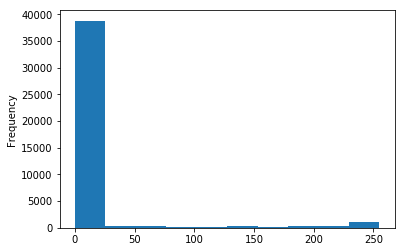

In [5]:
train.pixel100.plot(kind='hist')

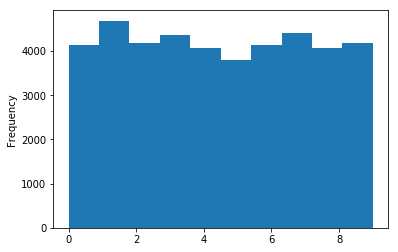

In [6]:
train.label.plot(kind='hist')

In [7]:
cols = test.columns.tolist()
len(cols)

784

In [8]:
X_train = train[cols].values
y_train = train['label'].values
X_test = test[cols].values

In [9]:
X_train.shape, y_train.shape

((42000, 784), (42000,))

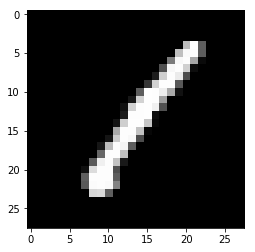

In [10]:
plt.imshow(X_train.reshape((-1, 28, 28))[0], cmap='gray')

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=768)

In [13]:
y_train.shape, y_val.shape

((37800,), (4200,))

In [14]:
np.bincount(y_train), np.bincount(y_val)

(array([3724, 4210, 3743, 3917, 3657, 3410, 3729, 3938, 3698, 3774]),
 array([408, 474, 434, 434, 415, 385, 408, 463, 365, 414]))

# Tensorflow DNN

In [15]:
y_train[:5]

array([6, 2, 0, 1, 6])

In [16]:
import tensorflow as tf
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

/home/zack/anaconda3/envs/dev/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## tf.layers.dense()

In [45]:
n_inputs = 28*28  # MNIST
n_hidden1 = 512
n_hidden2 = 128
n_outputs = 10
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

he_init = tf.contrib.layers.variance_scaling_initializer(mode="FAN_AVG")
with tf.name_scope("cnn"):
    X_reshaped = tf.reshape(X, [-1, 28, 28, 1])
    bn1 = tf.layers.batch_normalization(X_reshaped, axis=-1, training=training)
    conv1 = tf.layers.conv2d(bn1, filters=32, kernel_size=3, activation=tf.nn.leaky_relu)
    conv1 = tf.layers.conv2d(conv1, filters=32, kernel_size=3, activation=tf.nn.leaky_relu)
    conv1 = tf.layers.batch_normalization(conv1, axis=-1, training=training)
    conv1 = tf.layers.max_pooling2d(conv1, 2, 2)
    conv1 = tf.layers.dropout(conv1, 0.25, training=training)
    conv2 = tf.layers.conv2d(conv1, filters=64, kernel_size=3, activation=tf.nn.leaky_relu)
    conv2 = tf.layers.conv2d(conv2, filters=64, kernel_size=3, activation=tf.nn.leaky_relu)
    conv2 = tf.layers.batch_normalization(conv2, axis=-1, training=training)
    conv2 = tf.layers.max_pooling2d(conv2, 2, 2)
    conv2 = tf.layers.dropout(conv2, 0.25, training=training)
    flatten = tf.contrib.layers.flatten(conv2)
    hidden1 = tf.layers.dense(flatten, n_hidden1, name="hidden1", activation=tf.nn.leaky_relu,
                              kernel_initializer=he_init, kernel_regularizer=tf.contrib.layers.l2_regularizer(0.005))
    hidden1 = tf.layers.dropout(hidden1, 0.5, training=training)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2", activation=tf.nn.leaky_relu,
                              kernel_initializer=he_init, kernel_regularizer=tf.contrib.layers.l2_regularizer(0.005))
    hidden2 = tf.layers.dropout(hidden2, 0.5, training=training)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')

with tf.name_scope('train'):
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(0.001, global_step=global_step,
                                               decay_steps=2000, decay_rate=0.9, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        training_op = optimizer.minimize(loss, global_step=global_step)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [46]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 100
batch_size = 128
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    init.run()
    for epoch in range(n_epochs):
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        for i in range(X_train.shape[0]//batch_size):
            feed_dict = {X:X_train[indices[batch_size*i:batch_size*(i+1), ]], 
                         y:y_train[indices[batch_size*i:batch_size*(i+1), ]],
                         training:True}
            sess.run(training_op, feed_dict=feed_dict)
        acc_train = accuracy.eval(feed_dict={X:X_train[indices[:4200]], y:y_train[indices[:4200]]})
        acc_val = accuracy.eval(feed_dict={X:X_val, y:y_val})
        print('{} train_acc:{} val_acc:{}'.format(epoch, acc_train, acc_val))
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 train_acc:0.8557142615318298 val_acc:0.863095223903656
1 train_acc:0.967380940914154 val_acc:0.9685714244842529
2 train_acc:0.9871428608894348 val_acc:0.9819047451019287
3 train_acc:0.9900000095367432 val_acc:0.9850000143051147
4 train_acc:0.9926190376281738 val_acc:0.9866666793823242
5 train_acc:0.9942857027053833 val_acc:0.989047646522522
6 train_acc:0.9940476417541504 val_acc:0.9897618889808655
7 train_acc:0.9930952191352844 val_acc:0.9878571629524231
8 train_acc:0.9928571581840515 val_acc:0.989047646522522
9 train_acc:0.9921428561210632 val_acc:0.9892857074737549
10 train_acc:0.9940476417541504 val_acc:0.9900000095367432
11 train_acc:0.994523823261261 val_acc:0.9900000095367432
12 train_acc:0.9947618842124939 val_acc:0.9895238280296326
13 train_acc:0.9954761862754822 val_acc:0.9897618889808655
14 train_acc:0.994523823261261 val_acc:0.989047646522522
15 train_acc:0.9959523677825928 val_acc:0.988095223903656
16 train_acc:0.9930952191352844 val_acc:0.989047646522522
17 train_acc:0.9

In [47]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    Z = logits.eval(feed_dict={X:X_val})
    y_pred = np.argmax(Z, axis=1)
y_pred[:20], y_val[:20]

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


(array([6, 3, 1, 3, 1, 5, 1, 5, 9, 0, 1, 5, 8, 2, 1, 9, 9, 6, 3, 4]),
 array([6, 3, 1, 3, 1, 5, 1, 5, 9, 0, 1, 5, 8, 2, 1, 9, 9, 6, 3, 4]))

In [48]:
y_pred = []
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    for X_test_batch in np.split(X_test, 10):
        Z = logits.eval(feed_dict={X:X_test_batch})
        y_pred.append(np.argmax(Z, axis=1))
y_pred = np.hstack(y_pred)

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


In [49]:
df_submit = pd.DataFrame(y_pred, columns=['Label'])
df_submit.index += 1
df_submit.index.name = 'ImageId'
df_submit.to_csv('~/projects/kaggle/digit_recognizer/submit.csv', index=True)